<a href="https://colab.research.google.com/github/marco-scatassi/CasualNetworkProject/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%%capture
!apt install python3-dev graphviz libgraphviz-dev pkg-config
!pip install networkx pygraphviz matplotlib

In [2]:
import numpy as np
import pandas as pd
import networkx as nx

from networkx.drawing.nx_agraph import graphviz_layout
from typing import List

In [3]:
# Get machine epsilon.
e = np.finfo(np.float64).eps

# Learning Bayesian Networks from Big Data with Greedy Search

## Introduction

One of the main important task in the causal framework is the **causal discovery task**. The aim of which is to find the **causal model** underline some given observational data. 




In particular, using the tool of **causal network**, the discovery task became the task of identifying:
1. a Directed Acyclic Graph (DAG) and 
2. a set of conditional probability distribution.

These two subtasks are referred as:
1. structure learning
2. parameter learning

In order to *justify* the use of **causal network** we have to assume that the underlying causal process follows a **probability distribution** $P$. So that, the underlying process can be represented by means of **observational data** sampled from the distribution $P$.

In this notebook the focus will be on the activity of **structure learning**. Essentially, a partial implementation of the "**Algorithm 1** Greedy Search" described in the paper [1] will be provided.


### Algorithm 1: Greedy Search

This algorithm belong to the class of the so called **score-based** algorithm. Which means that it follows a certain **methodology to explore** the space of possible DAG using a provided **score function** to evaluate candidate DAGs. 

In the following, the portion of the Algorithm 1 that will be implemented in this notebook is described.

---

**Alghorithm 1** Greedy Search 

---

**Input**: a data set $D$ from $X$, an initial DAG $G$ (usually the empty DAG),
a score function $Score(G,D)$.

**Output**: the DAG $G_{max}$ that maximises $Score(G,D)$.
1. Compute the score of $G$, $S_G = Score(G,D)$.
2. Set $S_{max} = S_G$ and $G_{max} = G$.
3. **Hill climbing**: repeat as long as $S_{max}$ increases:
  1. for every possible arc addition, deletion or reversal in $G_{max}$ resulting in a DAG:
    1. compute the score of the modified DAG $G^∗$, $S_{G^∗} = Score(G^∗,D)$:
    2. if $S_{G^∗} > S_{max}$ and $S_{G^∗} > S_G$, set $G = G^∗$ and $S_G = S_{G^∗}$ .
  2. if $S_G > S_{max}$, set $S_{max} = S_G$ and $G_{max} = G$.
---

#### Input

The inputs needed by the algorithm are:
1. an initial DAG $G$, that is the DAG from which the search will start
2. a dataset $D$ and a score function $Score(G,D)$; these two elements are necessary to evaluate a DAG. Indeed, the score function provides a mathematical expression that can be used to compare a candidate DAG $G$ with collected data $D$. If the DAG has an high score, it is likely to **correctly represent** the structure of the causal model that has generated the data.

The score function used in this notebook is the log-likelihood ($LL$) and it will be described in a specific section.

#### Step 1 / 2

The first and second steps are simply initialization steps, and they consists in:
1. evaluate the initial DAG $G$ 
2. initialize the value of the variables $S_{max}$ and $G_{max}$. At the end of the procedure these quantity will correspond to the optimal DAG and its value with respect to the chosen score function

#### Step 3

A brief description of **hill climbing**. The **hill climbing** is an optimization technique that follows an iteratively procedure. The method produces at each iteration a set of candidate solution modifying the previous one in some way. Then it updates the current solution only if at least one of the new candidates has a better score than the actual solution, otherwise it stops.

The **hill climnbing** tecnhique belongs to the so called **local search** methods. Indeed, at each iteration, it explores new possible solutions obtained using a local move starting from the actual one. 


Furthermore, because it updates the current solutions only if a new, better solution is found, this method is only able to reach certainly the global maximum in **convex optimization** problems. Otherwise, it could get stacked in a **local maxima or minima**.

In **Algorithm 1** local moves correspond to:
- addition
- deletion
- reversal

the step:
- 1.1. compute a new candidate DAG applying one of the previous moves
- 1.2. verify if the new DAG is better that the best DAG obtained up to this moment and update the variables if necessary 


#### Output

The DAG which maximize the score function, that is a local optimal solution or the global optimal one. 

### Log-Likelihood (LL)

The score function used in the implementation of **Algorithm 1** is the log-likelihood (LL), which is defined as follows:

$$LL(\mathcal{G}|D)=\sum_{i=1}^n\sum_{j=1}^{q_i}\sum_{k=1}^{r_i}N_{ijk}\cdot \log \left( \frac{N_{ijk}}{N_{ij*}} \right)$$

where:
- $n$ is the number of vertices in $\mathcal{G}$, or the number of variables in $D$,
- $q_i$ is the number of possible configurations of $Pa(X_i)$,
- $r_i$ is the number of possible levels of $X_i$,
- $N_{ijk}$ is the absolute frequency of observing $X_i$ with the $j$-th configuration and the $k$-th level,
- and finally $N_{ij*} = \sum_{k=1}^{ri} N_{ijk}$.

We can derive the previous formula recalling that the given dataset $D$ on which applied the **Algorithm 1** is *discrete* and assuming that both $X$ and the $X_i$ are *multinomial* random variables.

Then, given a DAG $\mathcal{G}$ and assuming the probability of underlying process $P$ factorizes according to $\mathcal{G}$, we can write:

$$ P(X|G) =  ∏_{i=1}^n P(X_i|Pa(X_i)) $$

If the distribution of $X$ dependes on parameter $Θ$, we have:

$$ P(X|G,\Theta) =  ∏_{i=1}^n P(X_i|Pa(X_i), Θ_{X_i}) $$

where:

$$\bigcup_{i=1}^n \Theta_{X_i}=Θ$$

Assuming that both $X=(X_1,\dots,X_n)$ and $X_i$ are multinomial random variables. Local distributions take the form:

$$X_i|Pa(X_i) ∼ Mul(\pi_{ik|j}), \qquad \pi_{ik | j} = P(X_i = k |Pa(X_i)= j );$$

Obtaining the likelihood function:

$$ L(\mathcal{G}|x) = ∏_{i=1}^n ∏_{j=1}^{q_i} ∏_{k=1}^{r_i} \pi_{ik|j}^{x_{ijk}}$$

Applying the $\log$:

$$LL(\mathcal{G}|x) = \log(∏_{i=1}^n ∏_{j=1}^{q_i} ∏_{k=1}^{r_i} \pi_{ik|j}^{x_{ijk}}) = \sum_{i=1}^n \sum_{j=1}^{q_i} \sum_{k=1}^{r_i} \log(\pi_{ik|j}^{x_{ijk}})=\sum_{i=1}^n \sum_{j=1}^{q_i} \sum_{k=1}^{r_i} x_{ijk}\cdot\log(\pi_{ik|j})$$

Given a dataset $D$ obtained sampling from the distribution of $X$, we can substitute $x_{ijk}$ and $\pi_{ik|j}$ with $N_{ijk}$ and $\frac{N_{ijk}}{N_{ij*}}$ respectively.

So the $LL$ score function measure the likelihood of obtaining observed data $D$ if the true structure of the cuasal model is the one represented by the DAG $\mathcal{G}$.

## Implementation

### Read Data and Graph

In [5]:
# Read data from file.
D = pd.read_csv("./final_project_data.csv", dtype = "category")
# Build the true graph.
G = nx.DiGraph([
    ("A", "T"),
    ("S", "L"),
    ("S", "B"),
    ("B", "D"),
    ("E", "D"),
    ("T", "E"),
    ("L", "E"),
    ("E", "X")
])

In [13]:
D.head()

,A,S,T,L,B,E,X,D
0,no,yes,no,no,yes,no,no,yes
1,no,yes,no,no,no,no,no,no
2,no,no,yes,no,no,yes,yes,yes
3,no,no,no,no,yes,no,no,yes
4,no,no,no,no,no,no,no,yes


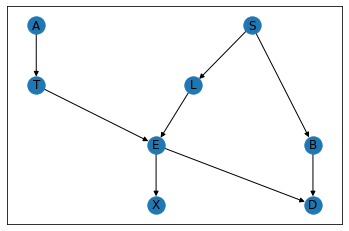

In [12]:
nx.draw_networkx(G, pos = graphviz_layout(G, prog = "dot"), with_labels = True)

### Computing the Absolute Frequencies

In [229]:
# Compute the absolute frequencies N(X, Pa(X) | D).
def N(X: str, Z: List[str], D: pd.DataFrame) -> np.ndarray:
    # 1. Add a fake column to D, (this is needed if a 
    # node is child of every other node)
    from copy import deepcopy
    D_ =  deepcopy(D)
    D_['fake'] = np.zeros((len(D),1))

    # 1. Group data with respect to provided variables
    abs_freq = D_.groupby([X]+Z)
    
    # 2. Count the number of observation in each group
    abs_freq = abs_freq.count()['fake']

    # 3. Cast the resulting Series in an numpy array
    abs_freq = abs_freq.to_numpy(dtype=np.ndarray)

    # 4. Re-shaping the array to match the dimension required
    if len(Z) == 0:
      t = (D[X].unique().size,1)
    else:
      t = (D[X].unique().size, 
           D[Z].apply(lambda x: tuple(x[s] for s in Z),axis=1).unique().size)
    
    abs_freq = abs_freq.reshape(t).T

    return abs_freq

In [230]:
# Compute N(A | D).
np.testing.assert_equal(
    N("A", [], D),
    np.array([[4958,   42]])
)

In [231]:
# Compute N(A, [L] | D).
np.testing.assert_equal(
    N("A", ["L"], D),
    np.array([
        [4632,   38],
        [ 326,    4]
    ])
)

In [233]:
# Compute N(A, [L, T] | D).
np.testing.assert_equal(
    N("A", ["L", "T"], D),
    np.array([
        [4594,   36],
        [  38,    2],
        [ 322,    4],
        [   4,    0]
    ])
)

### Computing the Log-Likelihood

In [341]:
# Compute log-likelihood of LL(X, Pa(X) | D).
def ll(X: str, Z: List[str], D: pd.DataFrame) -> float:
    # 1. Compute the absolute frequencies
    N_ijk = N(X, Z, D)

    # 2. Compute the sum of abs. freq. over possible levels of X
    N_ijstar = N_ijk.sum(axis=1).reshape((N_ijk.shape[0],1))

    # 3. Compute the relative frequencies 
    rel_freq = (N_ijk/N_ijstar).astype('float')

    # 4. Substitute 0 values with 1 (in order to avoid 
    #    inf value when apply the logarithm)
    rel_freq[rel_freq==0] = 1

    # 5. Apply the log to relative frequencies
    log_rel_freq = np.log(rel_freq.astype("float"))

    # 6. Weight the log relative frequencies
    weighted_log_rel_freq = (N_ijk * log_rel_freq).astype('float')

    # 7. Compute the log-likelihood 
    ll = weighted_log_rel_freq.sum()

    return ll

In [342]:
# Compute LL(A | D).
np.testing.assert_approx_equal(
    ll("A", [], D),
    -242.5631
)

In [343]:
# Compute LL(A, [L] | D).
np.testing.assert_approx_equal(
    ll("A", ["L"], D),
    -242.3023
)

In [344]:
# Compute LL(A, [L, T] | D).
np.testing.assert_approx_equal(
    ll("A", ["L", "T"], D),
    -240.2226
)

In [345]:
# Compute log-likelihood of LL(G | D).
def LL(G: nx.DiGraph, D: pd.DataFrame) -> float:
    nodes = G.nodes
    ll_ = [ll(X, list(G.predecessors(X)), D) for X in G.nodes]
    LL = sum(ll_)
    return LL

In [346]:
# Compute LL(G | D).
np.testing.assert_approx_equal(
    LL(G, D),
    -11033.0871
)

### Implementing Hill-Climbing

In [ ]:
# Hill-Climbing.
def HC(D: pd.DataFrame) -> nx.DiGraph:
    pass

In [ ]:
H = HC(D)

In [ ]:
nx.draw_networkx(H, pos = graphviz_layout(H, prog = "dot"), with_labels = True)

### Testing Hill-Climbing

## Reference

[1] [Marco Scutari, Claudia Vitolo, Allan Tucker. *Learning Bayesian networks from big data with greedy search:
computational complexity and efficient implementation*, Statistics and Computing (2019) 29:1095–1108, *https://doi.org/10.1007/s11222-019-09857-1*]